In [2]:
%cd IP-Adapter

/workspace/IP-Adapter


In [3]:
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipelineLegacy, DDIMScheduler, AutoencoderKL
from PIL import Image

from ip_adapter import IPAdapter

In [32]:
base_model_path = "runwayml/stable-diffusion-v1-5"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "models/models/image_encoder"
ip_ckpt = "models/models/ip-adapter_sd15.bin"
device = "cuda"

In [6]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

In [7]:
torch.cuda.empty_cache()
pipe = StableDiffusionInpaintPipelineLegacy.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_inpaint_legacy.py:144: FutureWarning: The class <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> is deprecated and will be removed in v1.0.0. You can achieve exactly the same functionalityby loading your model into `StableDiffusionInpaintPipeline` instead. See https://github.com/huggingface/diffusers/pull/3533for more information.
  deprecate("legacy is outdated", "1.0.0", deprecation_message, standard_warn=False)
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face stron

In [33]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

In [19]:
!pip install imageio


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip


In [24]:
import imageio
import gradio as gr

In [27]:
def infer(img, option):
  print(type(img))
  print(type(img["image"]))
  print(type(img["mask"]))
  imageio.imwrite("./data_mask.png", img["mask"])
  return "./data_mask.png"

In [28]:
inputs = [gr.Image(tool="sketch", label="Input",type="pil")]
outputs = [gr.outputs.Image(type="pil",label="Mask")]
title = "Image Inpainting"
description = "Gradio UI for creating image masks"
gr.Interface(infer, inputs, outputs, title=title, description=description).launch(share=True)

/tmp/ipykernel_27113/1659403601.py:2: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  outputs = [gr.outputs.Image(type="pil",label="Mask")]
/usr/local/lib/python3.10/dist-packages/gradio/utils.py:776: UserWarning: Expected 2 arguments for function <function infer at 0x7fda489b3640>, received 1.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/utils.py:780: UserWarning: Expected at least 2 arguments for function <function infer at 0x7fda489b3640>, received 1.
  warnings.warn(


Running on local URL:  http://127.0.0.1:7866
Running on public URL: https://10b7d1cb7edd2289c9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.10/dist-packages/gradio/helpers.py:779: UserWarning: Unexpected argument. Filling with None.
  warnings.warn("Unexpected argument. Filling with None.")


<class 'dict'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>


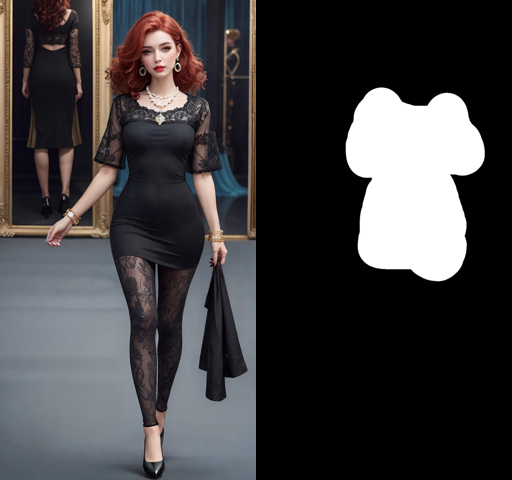

In [38]:
masked_image = Image.open("data.jpeg").resize((512, 960))
mask = Image.open("data_mask.png").resize((512, 960))
image_grid([masked_image.resize((256, 480)), mask.resize((256, 480))], 1, 2)

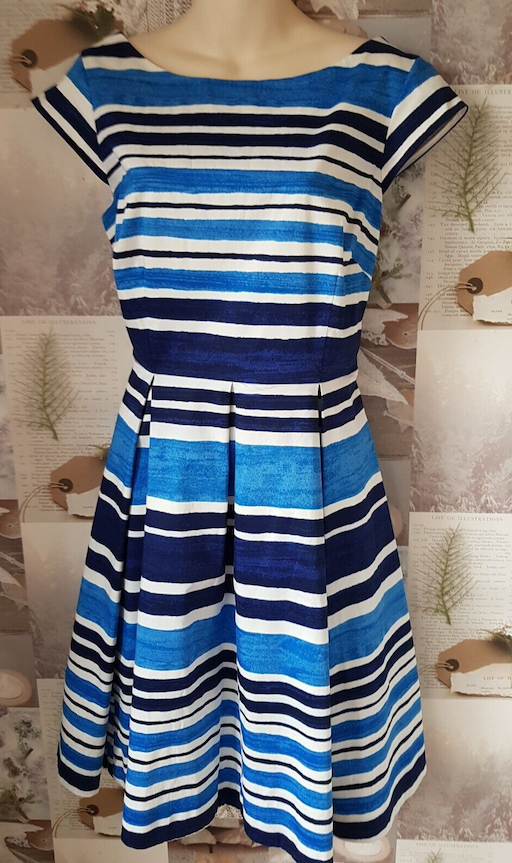

In [35]:
image = Image.open("dress.png")
image.resize((512, 863))

In [ ]:
image = Image.open("long-sleeve.jpg")
image.resize((512, 768))

  0%|          | 0/35 [00:00<?, ?it/s]

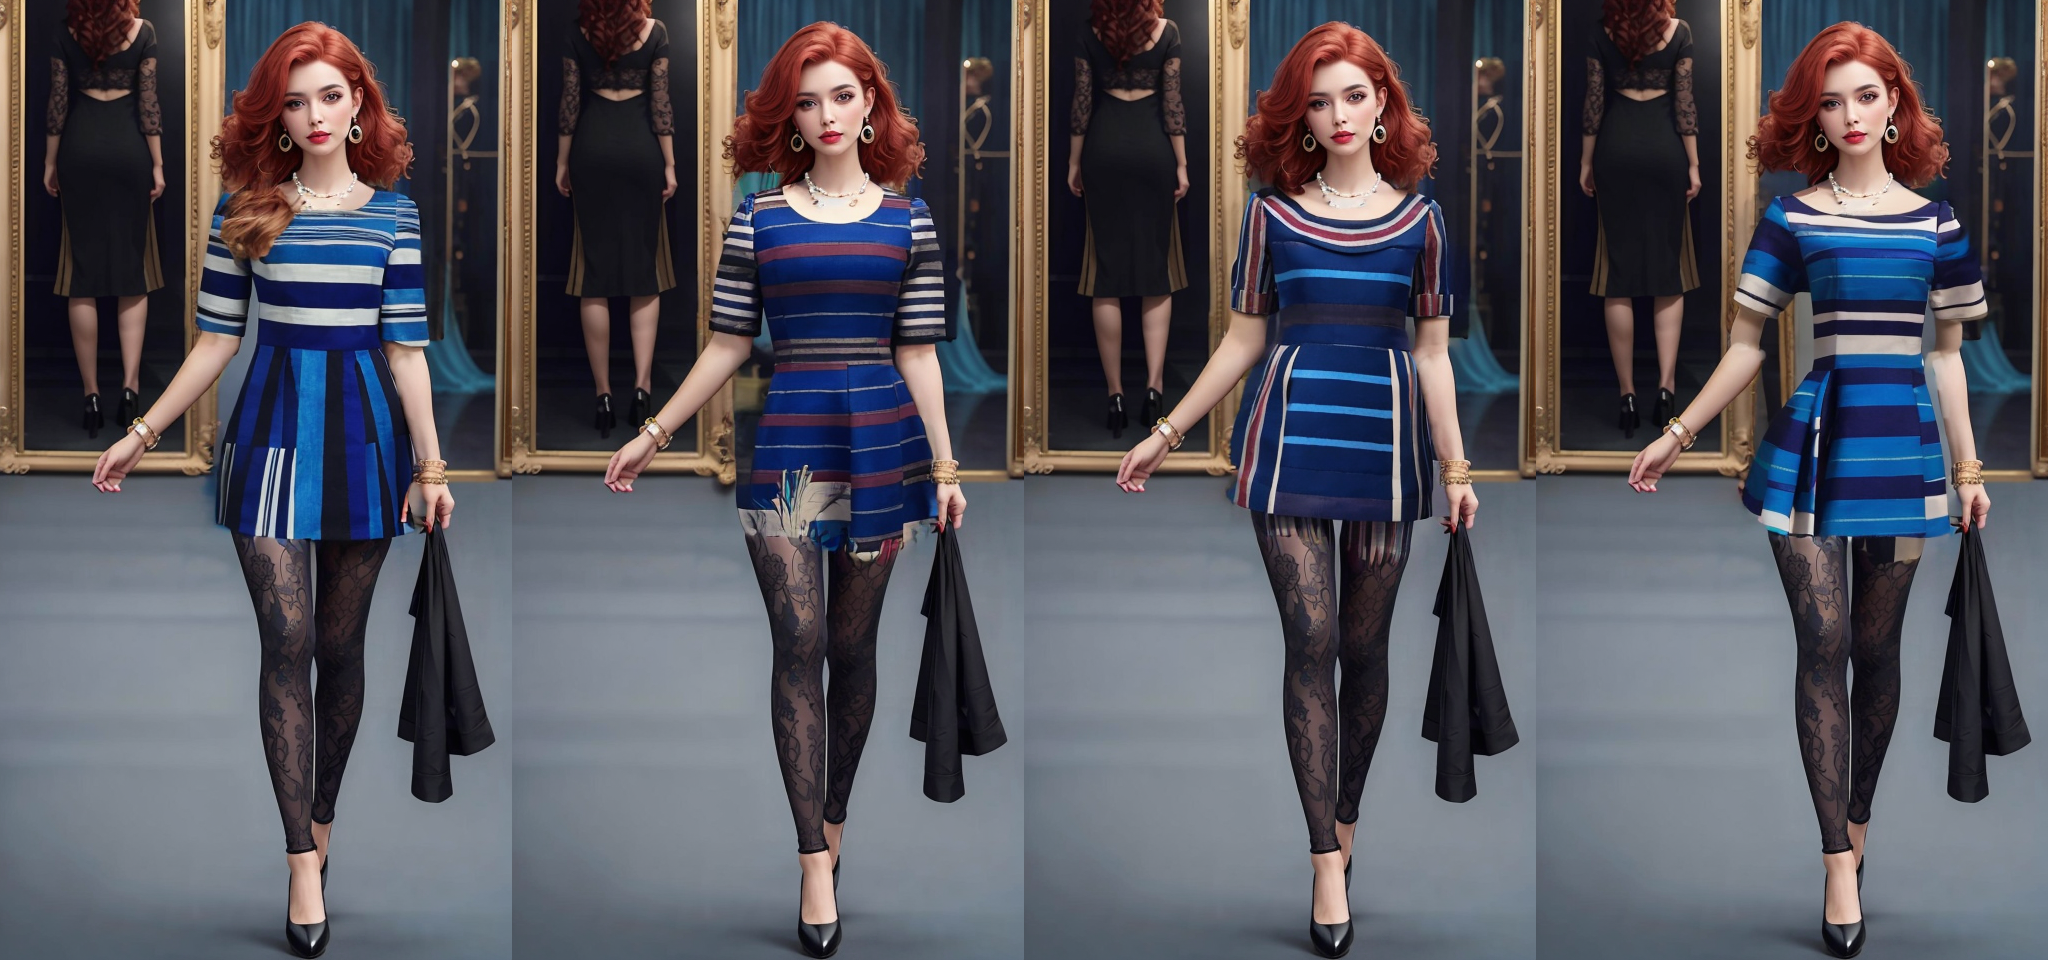

In [39]:
# generate
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50,
                           seed=42, image=masked_image, mask_image=mask, strength=0.7, )
grid = image_grid(images, 1, 4)
grid